In [1]:
# set the working directory to be the root of the package
# so that the imports work below
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import models.data_util

In [4]:
data_file = "../data/full.pkl"  # set this accordingly

# Load the lat/long for each company
x, y = models.data_util.load_raw_data(data_file, cols=['lat', 'long'])

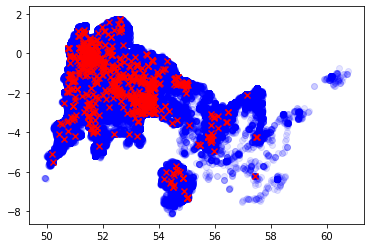

In [8]:
failedcomps = np.nonzero(y == 1)
notfailedcomps = np.nonzero(y == 0)

plt.scatter(x[notfailedcomps].T[0], x[notfailedcomps].T[1],
            marker='o', alpha=0.1, color='blue')
plt.scatter(x[failedcomps].T[0], x[failedcomps].T[1],
            marker='x', alpha=1.0, color='red')
plt.show()